
# ------------------------------------------------------------------
# Big Data Forecasting with Recurrent Neural Networks and PySpark
# ------------------------------------------------------------------


# Dataset - Persons Killed in Road Accidents in Europe

    The data on road fatalities in Europe, collected from Eurostat, covers the period from 1999 to 2022. These statistics include deaths that occur within 30 days of a road accident, following the “death within 30 days” principle. The dataset encompasses information from all EU Member States and EFTA countries, allowing for a consistent comparison across nations.

    Key aspects of the dataset include:

    - Annual total fatalities reported in road accidents.
    - Breakdown by vehicle type (e.g., cars, motorcycles, bicycles).
    - Demographic details like age and gender of the victims.
    - Information about the location and circumstances of accidents.
    
    This data shows a general decline in road fatalities over the years, attributed to improved road safety measures, better vehicle technology, and stricter regulations.
    
    References:
    - Eurostat - Road Safety Metadata: https://ec.europa.eu/eurostat/cache/metadata/en/tran_sf_road_esms.htm
    - Eurostat - Road Transport Safety Data: https://ec.europa.eu/eurostat/web/transport/data

# Connection PySpark 

In [1]:
sc

''

In [2]:
sc.master

# Loading the Packages

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [5]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import missingno as msno

from pyspark.sql.functions import expr
from pyspark.sql.functions import col, sum
from pyspark.sql import SparkSession

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization, TimeDistributed
from tensorflow.keras.layers import Activation
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout

# Reading the dataset from Hadoop 

In [8]:
sc = spark.sparkContext

In [9]:
path = '/user1/estat_tran_sf_roadus.txt'
death_roads = spark.read.csv(path, sep = '\t', header = True, inferSchema = True)

In [10]:
death_roads.show(truncate = False)

# Data Preparation

In [11]:
death_roads.toPandas()

,freq,sex,age,unit,pers_cat,geo\TIME_PERIOD,1999,2000,2001,2002,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
0,A,F,TOTAL,NR,DRIV,AT,129,100,112,105,...,49,61,65,57,48,49,53,45,54,56
1,A,F,TOTAL,NR,DRIV,BE,182,184,188,155,...,74,84,97,77,79,86,69,59,66,60
2,A,F,TOTAL,NR,DRIV,BG,:,:,:,:,...,:,:,:,23,29,24,31,23,18,21
3,A,F,TOTAL,NR,DRIV,CH,:,:,59,54,...,27,21,22,28,33,19,18,25,19,29
4,A,F,TOTAL,NR,DRIV,CY,:,:,:,:,...,3,3,7,2,4,1,4,2,4,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5064,A,UNK,Y_LT15,NR,UNK,HR,:,:,:,:,...,:,:,:,:,:,:,:,:,:,:
5065,A,UNK,Y_LT15,NR,UNK,LT,:,:,:,:,...,:,:,:,:,:,:,0,:,:,:
5066,A,UNK,Y_LT15,NR,UNK,NL,:,:,:,:,...,0,0,:,:,:,0,0,:,:,:
5067,A,UNK,Y_LT15,NR,UNK,SE,:,:,:,:,...,:,:,:,:,:,:,:,:,:,:


In [12]:
death_roads.printSchema()

root
 |-- freq: string (nullable = true)
 |-- sex: string (nullable = true)
 |-- age: string (nullable = true)
 |-- unit: string (nullable = true)
 |-- pers_cat: string (nullable = true)
 |-- geo\TIME_PERIOD: string (nullable = true)
 |-- 1999: string (nullable = true)
 |-- 2000: string (nullable = true)
 |-- 2001: string (nullable = true)
 |-- 2002: string (nullable = true)
 |-- 2003: string (nullable = true)
 |-- 2004: string (nullable = true)
 |-- 2005: string (nullable = true)
 |-- 2006: string (nullable = true)
 |-- 2007: string (nullable = true)
 |-- 2008: string (nullable = true)
 |-- 2009: string (nullable = true)
 |-- 2010: string (nullable = true)
 |-- 2011: string (nullable = true)
 |-- 2012: string (nullable = true)
 |-- 2013: string (nullable = true)
 |-- 2014: string (nullable = true)
 |-- 2015: string (nullable = true)
 |-- 2016: string (nullable = true)
 |-- 2017: string (nullable = true)
 |-- 2018: string (nullable = true)
 |-- 2019: string (nullable = true)
 |-- 2020:

- Counting the Number of Rows

In [13]:
row_count = death_roads.count()
print(f"Total number of rows: {row_count}")


Total number of rows: 5069


- Removing Columns

In [14]:
death_roads = death_roads.drop('freq', 'unit')

In [15]:
death_roads.toPandas()

,sex,age,pers_cat,geo\TIME_PERIOD,1999,2000,2001,2002,2003,2004,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
0,F,TOTAL,DRIV,AT,129,100,112,105,115,94,...,49,61,65,57,48,49,53,45,54,56
1,F,TOTAL,DRIV,BE,182,184,188,155,153,138,...,74,84,97,77,79,86,69,59,66,60
2,F,TOTAL,DRIV,BG,:,:,:,:,:,:,...,:,:,:,23,29,24,31,23,18,21
3,F,TOTAL,DRIV,CH,:,:,59,54,60,41,...,27,21,22,28,33,19,18,25,19,29
4,F,TOTAL,DRIV,CY,:,:,:,:,:,:,...,3,3,7,2,4,1,4,2,4,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5064,UNK,Y_LT15,UNK,HR,:,:,:,:,:,:,...,:,:,:,:,:,:,:,:,:,:
5065,UNK,Y_LT15,UNK,LT,:,:,:,:,:,:,...,:,:,:,:,:,:,0,:,:,:
5066,UNK,Y_LT15,UNK,NL,:,:,:,:,:,:,...,0,0,:,:,:,0,0,:,:,:
5067,UNK,Y_LT15,UNK,SE,:,:,:,:,:,:,...,:,:,:,:,:,:,:,:,:,:


- Renaming columnns

In [16]:
death_roads = death_roads.withColumnRenamed("geo\TIME_PERIOD", "country") \
       .withColumnRenamed("pers_cat", "involved")

- Transforming columns into rows

In [17]:
value_columns = [col for col in death_roads.columns if col not in ['sex','age','involved','country']]

d_roads = death_roads.selectExpr('sex',
                                 'age',
                                 'involved',
                                 'country', 
                                 "stack( {0}, {1}) as (year, value)".format(
                                     len(value_columns),
                                     ', '.join([f"'{col}', `{col}`" for col in value_columns])
                                )
)
                        

In [18]:
d_roads.toPandas()

,sex,age,involved,country,year,value
0,F,TOTAL,DRIV,AT,1999,129
1,F,TOTAL,DRIV,AT,2000,100
2,F,TOTAL,DRIV,AT,2001,112
3,F,TOTAL,DRIV,AT,2002,105
4,F,TOTAL,DRIV,AT,2003,115
...,...,...,...,...,...,...
121651,UNK,Y_LT15,UNK,SI,2018,:
121652,UNK,Y_LT15,UNK,SI,2019,:
121653,UNK,Y_LT15,UNK,SI,2020,:
121654,UNK,Y_LT15,UNK,SI,2021,:


- Counting the Number of Rows

In [19]:
row_count = d_roads.count()
print(f"Total number of rows: {row_count}")


Total number of rows: 121656


- Checking the distinct values for each variables

In [20]:
d_roads.select("age").distinct().show()

+------+
|   age|
+------+
|Y50-64|
|Y25-49|
|Y18-24|
|Y_GE65|
|Y_LT15|
|   UNK|
| TOTAL|
|Y15-17|
+------+



In [21]:
d_roads.select("involved").distinct().show()

+--------+
|involved|
+--------+
|     PED|
|     UNK|
|     PAS|
|   TOTAL|
|    DRIV|
+--------+



In [22]:
d_roads.select("country").distinct().show()

+---------+
|  country|
+---------+
|       LT|
|       FI|
|       RO|
|       NL|
|       PL|
|       EE|
|       AT|
|       HR|
|       LI|
|       CZ|
|       PT|
|       MT|
|       DE|
|       ES|
|EU27_2020|
|       FR|
|       CH|
|       IT|
|       SE|
|       BG|
+---------+
only showing top 20 rows



- Removing values from the variables

In [23]:
d_roads = d_roads.filter((d_roads['age'] != 'TOTAL') & 
                         (d_roads['involved'] != 'TOTAL'))
                      #   &(d_roads['country'] != 'EU27_2020')) 

# Missing Values

- Changing characters and strings to NULL in the variable 'value'

In [24]:
from pyspark.sql.functions import regexp_replace, col, when

d_roads = d_roads.withColumn('value',regexp_replace(col('value'),': ',''))
d_roads = d_roads.withColumn('value',regexp_replace(col('value'), r'[^\d.-]', ''))

valid_value_regex = r'^\d+(\.\d+)?$'
d_roads = d_roads.withColumn(
    "value",
    when(col("value").rlike(valid_value_regex), col("value").cast("double")).otherwise(None)
)

d_roads.toPandas()

,sex,age,involved,country,year,value
0,F,UNK,DRIV,AT,1999,0.0
1,F,UNK,DRIV,AT,2000,0.0
2,F,UNK,DRIV,AT,2001,0.0
3,F,UNK,DRIV,AT,2002,0.0
4,F,UNK,DRIV,AT,2003,0.0
...,...,...,...,...,...,...
69907,UNK,Y_LT15,UNK,SI,2018,NaN
69908,UNK,Y_LT15,UNK,SI,2019,NaN
69909,UNK,Y_LT15,UNK,SI,2020,NaN
69910,UNK,Y_LT15,UNK,SI,2021,NaN


In [25]:
d_roads.printSchema()

root
 |-- sex: string (nullable = true)
 |-- age: string (nullable = true)
 |-- involved: string (nullable = true)
 |-- country: string (nullable = true)
 |-- year: string (nullable = true)
 |-- value: double (nullable = true)



- Removing Missing Values

In [26]:
d_roads = d_roads.na.drop()
d_roads.toPandas()

,sex,age,involved,country,year,value
0,F,UNK,DRIV,AT,1999,0.0
1,F,UNK,DRIV,AT,2000,0.0
2,F,UNK,DRIV,AT,2001,0.0
3,F,UNK,DRIV,AT,2002,0.0
4,F,UNK,DRIV,AT,2003,0.0
...,...,...,...,...,...,...
50356,UNK,Y_LT15,UNK,NL,2018,0.0
50357,UNK,Y_LT15,UNK,NL,2019,0.0
50358,UNK,Y_LT15,UNK,SE,2011,0.0
50359,UNK,Y_LT15,UNK,SE,2012,0.0


- Changing the format of the variable 'value' to 'float64'

In [27]:
d_roads = d_roads.withColumn('value', col('value').cast('int'))

In [28]:
d_roads.printSchema()

root
 |-- sex: string (nullable = true)
 |-- age: string (nullable = true)
 |-- involved: string (nullable = true)
 |-- country: string (nullable = true)
 |-- year: string (nullable = true)
 |-- value: integer (nullable = true)



# Exploratory Data Analysis (EDA)

## Describing the Dataset

- Checking the dataset features

In [29]:
d_roads.toPandas()

,sex,age,involved,country,year,value
0,F,UNK,DRIV,AT,1999,0
1,F,UNK,DRIV,AT,2000,0
2,F,UNK,DRIV,AT,2001,0
3,F,UNK,DRIV,AT,2002,0
4,F,UNK,DRIV,AT,2003,0
...,...,...,...,...,...,...
50356,UNK,Y_LT15,UNK,NL,2018,0
50357,UNK,Y_LT15,UNK,NL,2019,0
50358,UNK,Y_LT15,UNK,SE,2011,0
50359,UNK,Y_LT15,UNK,SE,2012,0


In [30]:
d_roads.printSchema()

root
 |-- sex: string (nullable = true)
 |-- age: string (nullable = true)
 |-- involved: string (nullable = true)
 |-- country: string (nullable = true)
 |-- year: string (nullable = true)
 |-- value: integer (nullable = true)



- Describing the dataset

In [31]:
d_roads.describe().show()

+-------+-----+------+--------+-------+------------------+------------------+
|summary|  sex|   age|involved|country|              year|             value|
+-------+-----+------+--------+-------+------------------+------------------+
|  count|50361| 50361|   50361|  50361|             50361|             50361|
|   mean| null|  null|    null|   null|2011.1119715652985| 68.06000675125593|
| stddev| null|  null|    null|   null| 6.647680193331159|386.72557611361003|
|    min|    F|   UNK|    DRIV|     AT|              1999|                 0|
|    max|  UNK|Y_LT15|     UNK|     UK|              2022|             20264|
+-------+-----+------+--------+-------+------------------+------------------+



In [32]:
from pyspark.sql.functions import mean, stddev, min, max

# Calcular estatísticas personalizadas para a coluna 'value'
d_roads.agg(
    mean("value").alias("mean_value"),
    stddev("value").alias("stddev_value"),
    min("value").alias("min_value"),
    max("value").alias("max_value")
).show()

+-----------------+------------------+---------+---------+
|       mean_value|      stddev_value|min_value|max_value|
+-----------------+------------------+---------+---------+
|68.06000675125593|386.72557611361003|        0|    20264|
+-----------------+------------------+---------+---------+



## Graphical Analysis

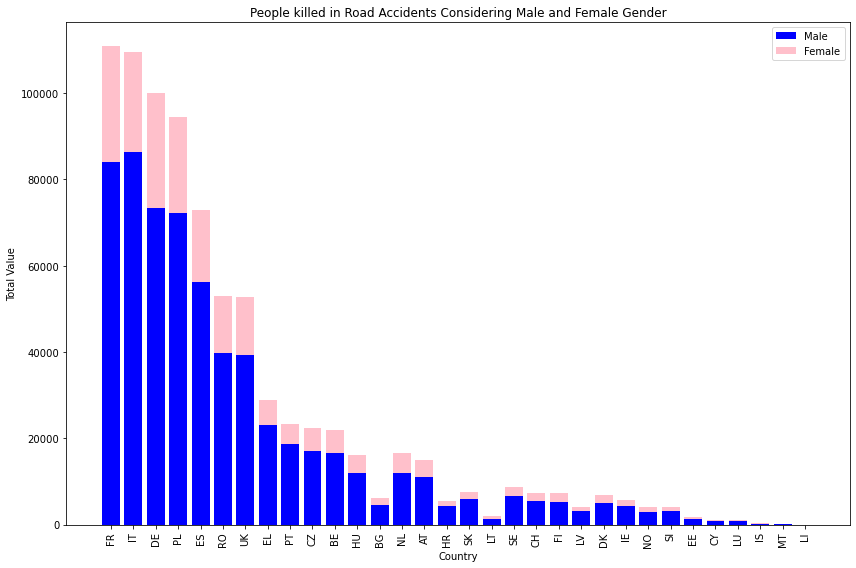

In [33]:
# Filtering the DataFrame to exclude 'EU27_2020' from the country column
filtered_d_roads = d_roads.filter(col("country") != "EU27_2020")

# Aggregating the data by country and sex, summing the 'value' column
result_df_filtered = filtered_d_roads.groupBy("country", "sex") \
                                     .agg(sum("value").alias("total_value")) \
                                     .orderBy(col("total_value").desc()) \
                                     .toPandas()

# Pivot the DataFrame to have 'sex' as columns for plotting
pivot_df = result_df_filtered.pivot(index='country', columns='sex', values='total_value').fillna(0)

# Sorting the DataFrame by the sum of 'F' and 'M' values 
pivot_df['total'] = pivot_df.sum(axis=1)
pivot_df = pivot_df.sort_values(by='total', ascending=False)

# Plotting the stacked bar chart
plt.figure(figsize=(12, 8))
plt.bar(pivot_df.index, pivot_df['M'], label='Male', color='blue')
plt.bar(pivot_df.index, pivot_df['F'], bottom=pivot_df['M'], label='Female', color='pink')
#plt.bar(pivot_df.index, pivot_df['T'], bottom=pivot_df['F'], label='Transgender', color='brown')
#plt.bar(pivot_df.index, pivot_df['UNK'], bottom=pivot_df['T'], label='Unknown', color='grey')
plt.xlabel('Country')
plt.ylabel('Total Value')
plt.title('People killed in Road Accidents Considering Male and Female Gender')
plt.xticks(rotation=90) 
plt.legend()  # Adding a legend to differentiate male and female values
plt.tight_layout()
plt.show()


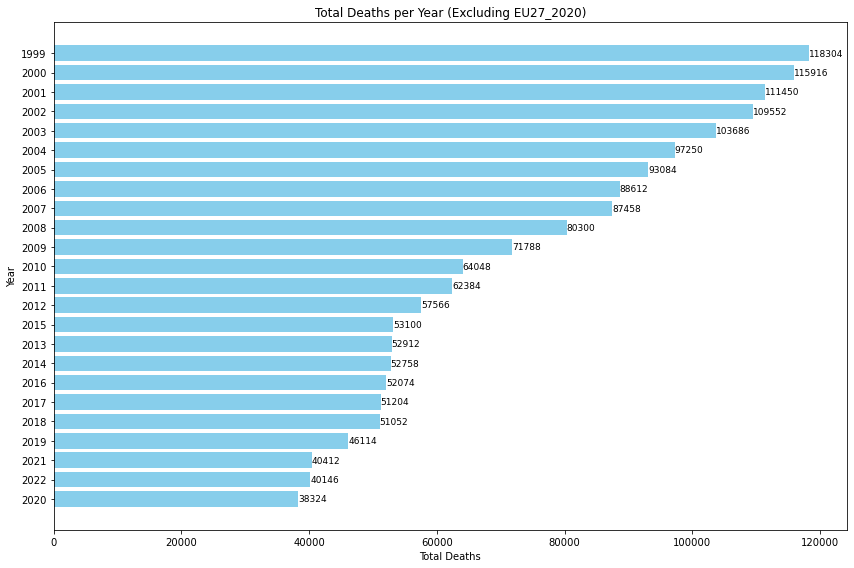

In [34]:
# Filtering the DataFrame to exclude 'EU27_2020' from the country column
filtered_d_roads = d_roads.filter(col("country") != "EU27_2020")

# Aggregating the data by year, summing the 'value' column
result_df_year = filtered_d_roads.groupBy("year") \
                                 .agg(sum("value").alias("total_value")) \
                                 .orderBy(col("total_value").desc()) \
                                 .toPandas()

# Plotting the horizontal bar chart
plt.figure(figsize=(12, 8))
bars = plt.barh(result_df_year['year'], result_df_year['total_value'], color='skyblue')
plt.xlabel('Total Deaths')
plt.ylabel('Year')
plt.title('Total Deaths per Year (Excluding EU27_2020)')

# Adding labels to each bar
for bar in bars:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, f'{int(bar.get_width())}', 
             va='center', ha='left', fontsize=9)

plt.gca().invert_yaxis()  # Invert the y-axis to have the highest values at the top
plt.tight_layout()
plt.show()



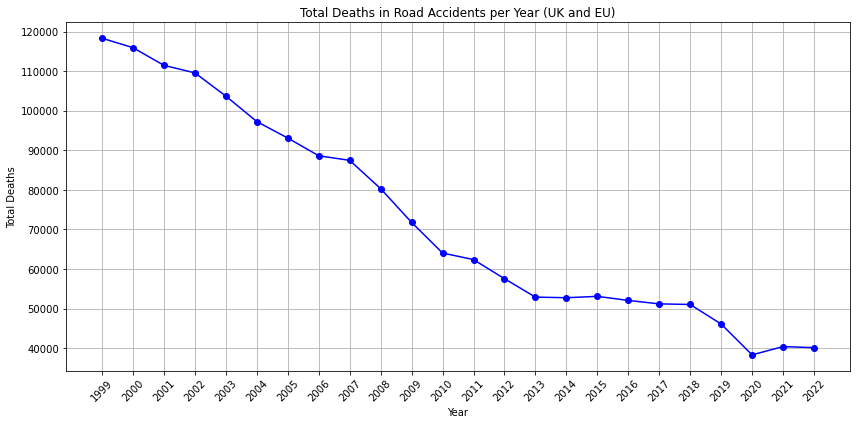

In [35]:

from pyspark.sql.functions import col, sum

# Filtering the DataFrame to exclude 'EU27_2020' from the country column
filtered_d_roads = d_roads.filter(col("country") != "EU27_2020")

# Aggregating the data by year, summing the 'value' column and ordering by year
result_df_year = filtered_d_roads.groupBy("year") \
                                 .agg(sum("value").alias("total_value")) \
                                 .orderBy(col("year").asc()) \
                                 .toPandas()

# Plotting the line chart
plt.figure(figsize=(12, 6))
plt.plot(result_df_year['year'], result_df_year['total_value'], marker='o', linestyle='-', color='blue')
plt.xlabel('Year')
plt.ylabel('Total Deaths')
plt.title('Total Deaths in Road Accidents per Year (UK and EU)')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.grid(True)  # Add a grid for better visual reference
plt.tight_layout()
plt.show()


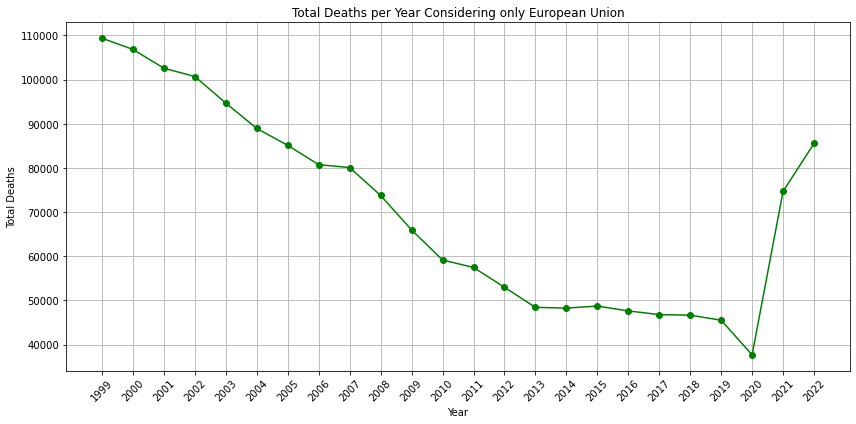

In [36]:

# Filtering the DataFrame to include only 'EU27_2020' from the country column
filtered_eu_d_roads = d_roads.filter(col("country") == "EU27_2020")

# Aggregating the data by year, summing the 'value' column and ordering by year
result_df_eu_year = filtered_eu_d_roads.groupBy("year") \
                                       .agg(sum("value").alias("total_value")) \
                                       .orderBy(col("year").asc()) \
                                       .toPandas()

# Plotting the line chart for EU27_2020
plt.figure(figsize=(12, 6))
plt.plot(result_df_eu_year['year'], result_df_eu_year['total_value'], marker='o', linestyle='-', color='green')
plt.xlabel('Year')
plt.ylabel('Total Deaths')
plt.title('Total Deaths per Year Considering only European Union')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.grid(True)  # Add a grid for better visual reference
plt.tight_layout()
plt.show()


#  Linear Regression Extrapolation

Linear Regression Extrapolation is a technique used to predict values outside the range of observed data by extending the trend captured by a linear regression model. It assumes that the relationship between the variables continues in the same linear pattern beyond the known data points. By fitting a straight line to the existing data, this method allows for estimating future or past values based on the slope and intercept of the regression line, making it useful for time series forecasting or filling missing data.

## Preparing the Dataset

In [37]:
d_roads.toPandas()

,sex,age,involved,country,year,value
0,F,UNK,DRIV,AT,1999,0
1,F,UNK,DRIV,AT,2000,0
2,F,UNK,DRIV,AT,2001,0
3,F,UNK,DRIV,AT,2002,0
4,F,UNK,DRIV,AT,2003,0
...,...,...,...,...,...,...
50356,UNK,Y_LT15,UNK,NL,2018,0
50357,UNK,Y_LT15,UNK,NL,2019,0
50358,UNK,Y_LT15,UNK,SE,2011,0
50359,UNK,Y_LT15,UNK,SE,2012,0


### Total Deaths by Year

In [38]:
filtered_d_roads = d_roads.filter(col("country") != "EU27_2020")

dr_year_pre = filtered_d_roads.groupBy("year") \
                                 .agg(sum("value").alias("total_value")) \
                                 .orderBy(col("year")) \
                                 .toPandas()

In [39]:
dr_year_pre

,year,total_value
0,1999,118304
1,2000,115916
2,2001,111450
3,2002,109552
4,2003,103686
5,2004,97250
6,2005,93084
7,2006,88612
8,2007,87458
9,2008,80300


### Total Deaths by Year - European Union 

In [40]:
filtered_d_roads_EU = d_roads.filter(col("country") == "EU27_2020")

dr_year_pre_EU = filtered_d_roads_EU.groupBy("year") \
                                       .agg(sum("value").alias("total_value")) \
                                       .orderBy(col("year")) \
                                       .toPandas()

In [41]:
dr_year_pre_EU

,year,total_value
0,1999,109360
1,2000,106820
2,2001,102564
3,2002,100686
4,2003,94662
5,2004,88932
6,2005,85104
7,2006,80730
8,2007,80076
9,2008,73760


### Total Deaths by Year and Sex

In [42]:
dr_sex_male_filtered = d_roads.filter((col("sex") == "M")  & (col("country") != "EU27_2020") )
dr_sex_female_filtered = d_roads.filter((col("sex") == "F")  & (col("country") != "EU27_2020") )

dr_sex_male_pre = dr_sex_male_filtered.groupBy("year") \
                                       .agg(sum("value").alias("total_value")) \
                                       .orderBy(col("year")) \
                                       .toPandas()

dr_sex_female_pre = dr_sex_female_filtered.groupBy("year") \
                                           .agg(sum("value").alias("total_value")) \
                                           .orderBy(col("year")) \
                                           .toPandas()

In [43]:
dr_sex_female_pre[['total_value']].values

array([[ 9484],
       [12573],
       [12722],
       [12264],
       [11483],
       [10896],
       [10512],
       [ 9934],
       [ 9696],
       [ 9402],
       [ 8489],
       [ 7329],
       [ 7062],
       [ 6536],
       [ 6187],
       [ 6156],
       [ 6064],
       [ 6293],
       [ 6140],
       [ 6096],
       [ 5278],
       [ 4191],
       [ 4352],
       [ 4584]], dtype=int64)

## Applying Linear Regression Extrapolation to the Dataset

### Convert the 'year' column to datetime

- Total Deaths by Year 

In [44]:
dr_year_pre['year'] = pd.to_datetime(dr_year_pre['year'], format='%Y')

- Total Deaths by Year - European Union 

In [45]:
dr_year_pre_EU['year'] = pd.to_datetime(dr_year_pre_EU['year'], format='%Y')

- Total Deaths by Year and Sex - Male

In [46]:
dr_sex_male_pre['year'] = pd.to_datetime(dr_sex_male_pre['year'], format='%Y')

- Total Deaths by Year and Sex - Female

In [47]:
dr_sex_female_pre['year'] = pd.to_datetime(dr_sex_female_pre['year'], format='%Y')

### Perform Linear Regression

- Total Deaths by Year 

In [48]:
X = np.array(dr_year_pre['year'].dt.year).reshape(-1, 1)
y = dr_year_pre['total_value']

model_dr_year_pre = LinearRegression()
model_dr_year_pre.fit(X, y)

LinearRegression()

- Total Deaths by Year - European Union 

In [49]:
X = np.array(dr_year_pre_EU['year'].dt.year).reshape(-1, 1)
y = dr_year_pre_EU['total_value']

model_dr_year_pre_EU = LinearRegression()
model_dr_year_pre_EU.fit(X, y)

LinearRegression()

- Total Deaths by Year and Sex - Male

In [50]:
X = np.array(dr_sex_male_pre['year'].dt.year).reshape(-1, 1)
y = dr_sex_male_pre['total_value']

model_dr_sex_male_pre = LinearRegression()
model_dr_sex_male_pre.fit(X, y)

LinearRegression()

- Total Deaths by Year and Sex - Female

In [51]:
X = np.array(dr_sex_female_pre['year'].dt.year).reshape(-1, 1)
y = dr_sex_female_pre['total_value']

model_dr_sex_female_pre = LinearRegression()
model_dr_sex_female_pre.fit(X, y)

LinearRegression()

### Simulating the Values for the 15 Previous Years

- Total Deaths by Year 

In [52]:
new_years_dr_year_pre = np.arange(1984, 1999).reshape(-1, 1)  # 15 years before 1999
predicted_values_dr_year_pre = model_dr_year_pre.predict(new_years_dr_year_pre)

- Total Deaths by Year - European Union 

In [53]:
new_years_dr_year_pre_EU = np.arange(1984, 1999).reshape(-1, 1)  # 15 years before 1999
predicted_values_dr_year_pre_EU = model_dr_year_pre_EU.predict(new_years_dr_year_pre_EU)

- Total Deaths by Year and Sex - Male

In [54]:
new_years_dr_sex_male_pre = np.arange(1984, 1999).reshape(-1, 1)  # 15 years before 1999
predicted_values_dr_sex_male_pre = model_dr_sex_male_pre.predict(new_years_dr_sex_male_pre)

- Total Deaths by Year and Sex - Female

In [55]:
new_years_dr_sex_female_pre = np.arange(1984, 1999).reshape(-1, 1)  # 15 years before 1999
predicted_values_dr_sex_female_pre = model_dr_sex_female_pre.predict(new_years_dr_sex_female_pre)

### Adding Noise to the Extrapolated Data

- Total Deaths by Year 

In [56]:
noise_dr_year_pre = np.random.normal(0, 2000, len(predicted_values_dr_year_pre))  # Noise with a smaller standard deviation (2000)
predicted_values_with_noise_dr_year_pre = predicted_values_dr_year_pre + noise_dr_year_pre

- Total Deaths by Year - European Union 

In [57]:
noise_dr_year_pre_EU = np.random.normal(0, 2000, len(predicted_values_dr_year_pre_EU))  # Noise with a smaller standard deviation (2000)
predicted_values_with_noise_dr_year_pre_EU = predicted_values_dr_year_pre_EU + noise_dr_year_pre_EU

- Total Deaths by Year and Sex - Male

In [58]:
noise_dr_sex_male_pre= np.random.normal(0, 2000, len(predicted_values_dr_sex_male_pre))  # Noise with a smaller standard deviation (2000)
predicted_values_with_noise_dr_sex_male_pre = predicted_values_dr_sex_male_pre + noise_dr_sex_male_pre

- Total Deaths by Year and Sex - Female

In [59]:
noise_dr_sex_female_pre= np.random.normal(0, 2000, len(predicted_values_dr_sex_female_pre))  # Noise with a smaller standard deviation (2000)
predicted_values_with_noise_dr_sex_female_pre = predicted_values_dr_sex_female_pre + noise_dr_sex_female_pre

In [60]:
predicted_values_with_noise_dr_sex_female_pre

array([17504.96746301, 17436.32354693, 17758.28532781, 16284.56051565,
       15443.66059224, 17345.56455256, 15945.92988049, 15318.80587707,
       14782.41760884, 11996.25884479, 14387.90815463, 15012.67586083,
       12777.0735892 , 12497.56623154, 16100.3214107 ])

### Plotting the Graph with The Original and Extrapolated Data

- Total Deaths by Year 

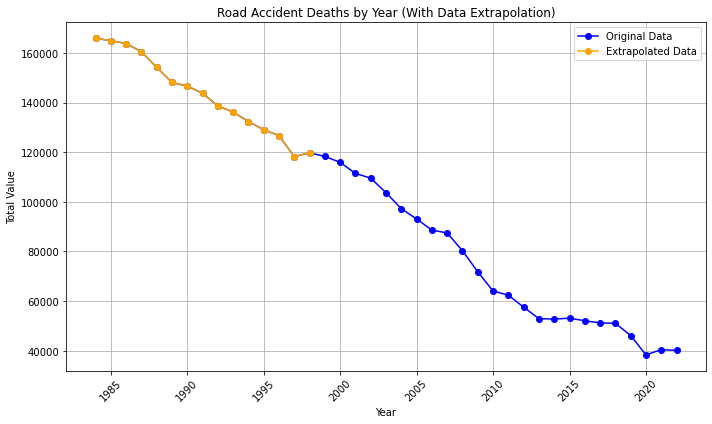

In [61]:
# Creating a DataFrame with the previous years and the predicted values with noise
df_new_years_dr_year_pre = pd.DataFrame({
    'year': pd.to_datetime(new_years_dr_year_pre.flatten(), format='%Y'),
    'total_value': predicted_values_with_noise_dr_year_pre
})

# Concatenating the original data with the predicted years
df_final_dr_year_pre = pd.concat([df_new_years_dr_year_pre, dr_year_pre])
df_final_dr_year_pre = df_final_dr_year_pre.reset_index(drop=True)

# Plotting the graph 
plt.figure(figsize=(10,6))
df_full_dr_year_pre = pd.concat([df_new_years_dr_year_pre, dr_year_pre])
plt.plot(df_full_dr_year_pre['year'], df_full_dr_year_pre['total_value'], marker='o', label='Original Data', color='blue')
plt.plot(df_new_years_dr_year_pre['year'], df_new_years_dr_year_pre['total_value'], marker='o', linestyle='-', label='Extrapolated Data', color='orange')
plt.title('Road Accident Deaths by Year (With Data Extrapolation)')
plt.xlabel('Year')
plt.ylabel('Total Value')
plt.grid(True)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()

# Show the plot
plt.show()


- Total Deaths by Year - European Union 

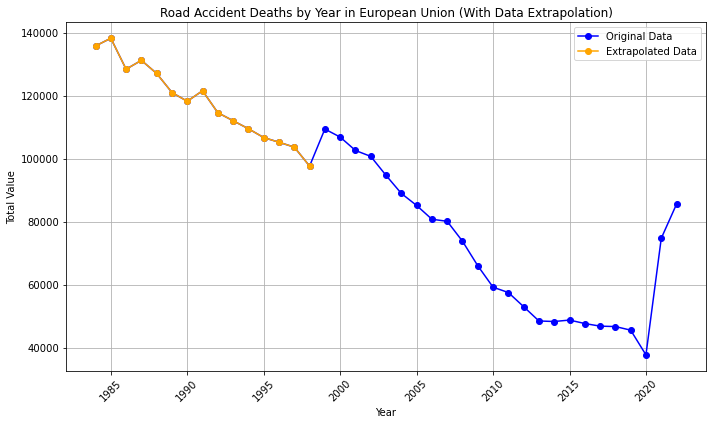

In [62]:
# Creating a DataFrame with the previous years and the predicted values with noise
df_new_years_dr_year_pre_EU = pd.DataFrame({
    'year': pd.to_datetime(new_years_dr_year_pre_EU.flatten(), format='%Y'),
    'total_value': predicted_values_with_noise_dr_year_pre_EU
})

# Concatenating the original data with the predicted years
df_final_dr_year_pre_EU = pd.concat([df_new_years_dr_year_pre_EU, dr_year_pre_EU])
df_final_dr_year_pre_EU = df_final_dr_year_pre_EU.reset_index(drop=True)

# Plotting the graph 
plt.figure(figsize=(10,6))
df_full_dr_year_pre_EU = pd.concat([df_new_years_dr_year_pre_EU, dr_year_pre_EU])
plt.plot(df_full_dr_year_pre_EU['year'], df_full_dr_year_pre_EU['total_value'], marker='o', label='Original Data', color='blue')
plt.plot(df_new_years_dr_year_pre_EU['year'], df_new_years_dr_year_pre_EU['total_value'], marker='o', linestyle='-', label='Extrapolated Data', color='orange')
plt.title('Road Accident Deaths by Year in European Union (With Data Extrapolation)')
plt.xlabel('Year')
plt.ylabel('Total Value')
plt.grid(True)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()

# Show the plot
plt.show()

- Total Deaths by Year and Sex - Male

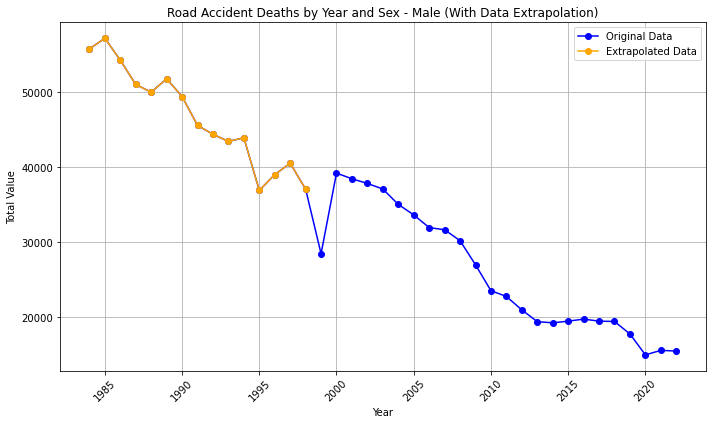

In [63]:
# Creating a DataFrame with the previous years and the predicted values with noise
df_new_years_dr_sex_male_pre = pd.DataFrame({
    'year': pd.to_datetime(new_years_dr_sex_male_pre.flatten(), format='%Y'),
    'total_value': predicted_values_with_noise_dr_sex_male_pre
})

# Concatenating the original data with the predicted years
df_final_dr_sex_male_pre = pd.concat([df_new_years_dr_sex_male_pre, dr_sex_male_pre])
df_final_dr_sex_male_pre = df_final_dr_sex_male_pre.reset_index(drop=True)

# Plotting the graph 
plt.figure(figsize=(10,6))
df_full_dr_sex_male_pre = pd.concat([df_new_years_dr_sex_male_pre, dr_sex_male_pre])
plt.plot(df_full_dr_sex_male_pre['year'], df_full_dr_sex_male_pre['total_value'], marker='o', label='Original Data', color='blue')
plt.plot(df_new_years_dr_sex_male_pre['year'], df_new_years_dr_sex_male_pre['total_value'], marker='o', linestyle='-', label='Extrapolated Data', color='orange')
plt.title('Road Accident Deaths by Year and Sex - Male (With Data Extrapolation)')
plt.xlabel('Year')
plt.ylabel('Total Value')
plt.grid(True)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()

# Show the plot
plt.show()

- Total Deaths by Year and Sex - Female

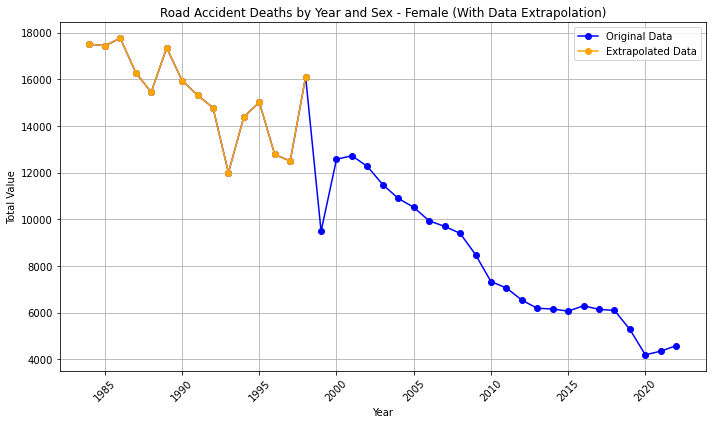

In [64]:
# Creating a DataFrame with the previous years and the predicted values with noise
df_new_years_dr_sex_female_pre = pd.DataFrame({
    'year': pd.to_datetime(new_years_dr_sex_female_pre.flatten(), format='%Y'),
    'total_value': predicted_values_with_noise_dr_sex_female_pre
})

# Concatenating the original data with the predicted years
df_final_dr_sex_female_pre = pd.concat([df_new_years_dr_sex_female_pre, dr_sex_female_pre])
df_final_dr_sex_female_pre = df_final_dr_sex_female_pre.reset_index(drop=True)

# Plotting the graph 
plt.figure(figsize=(10,6))
df_full_dr_sex_female_pre = pd.concat([df_new_years_dr_sex_female_pre, dr_sex_female_pre])
plt.plot(df_full_dr_sex_female_pre['year'], df_full_dr_sex_female_pre['total_value'], marker='o', label='Original Data', color='blue')
plt.plot(df_new_years_dr_sex_female_pre['year'], df_new_years_dr_sex_female_pre['total_value'], marker='o', linestyle='-', label='Extrapolated Data', color='orange')
plt.title('Road Accident Deaths by Year and Sex - Female (With Data Extrapolation)')
plt.xlabel('Year')
plt.ylabel('Total Value')
plt.grid(True)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()

# Show the plot
plt.show()

### Renaming Datasets

In [65]:
dr_year = df_full_dr_year_pre
dr_year_EU = df_full_dr_year_pre_EU
dr_sex_male = df_full_dr_sex_male_pre
dr_sex_female = df_full_dr_sex_female_pre

# Feature Engineering

### Setting the Number of Previous Observations for Prediction

In [66]:
previous_years = 15

## Splitting the Dataset in Train and Test

- Total Deaths by Year 

In [67]:
dr_year_v = dr_year[['total_value']].values

- Total Deaths by Year - European Union 

In [68]:
dr_year_v_EU = dr_year_EU[['total_value']].values

- Total Deaths by Year and Sex - Male

In [69]:
dr_sex_male_v =dr_sex_male[['total_value']].values

- Total Deaths by Year and Sex - Female

In [70]:
dr_sex_female_v = dr_sex_female[['total_value']].values

### Defining the Size of Train Sample

In [71]:
training_data_len = math.ceil( len(dr_year) * .8 )

In [72]:
training_data_len

32

### Splitting the Datasets

In [73]:
train_data_dr_year = dr_year_v[0:training_data_len , :]
train_data_dr_year_EU = dr_year_v_EU[0:training_data_len , :]
train_data_dr_sex_male = dr_sex_male_v[0:training_data_len , :]
train_data_dr_sex_female= dr_sex_female_v[0:training_data_len , :]

# Recurrent Neural Networking

## RNN for Total Deaths by Year

### Creating a Loop to Define Training Variables and the Target Variable

In [74]:
x_train_dr_year =[]
y_train_dr_year =[]

for i in range(previous_years, len(train_data_dr_year)):
    x_train_dr_year.append(train_data_dr_year[i-previous_years:i,0])
    y_train_dr_year.append(train_data_dr_year[i,0])
    
x_train_dr_year = np.array(x_train_dr_year)
y_train_dr_year = np.array(y_train_dr_year)

#### Normalizing Train Data

In [75]:
scaler = MinMaxScaler(feature_range=(0, 1))
x_train_scaled = scaler.fit_transform(x_train_dr_year)
y_train_scaled = scaler.fit_transform(y_train_dr_year.reshape(-1, 1))

- Converting in Numpy Arrays to Train the LTSM Neural Net model

In [76]:
x_train_scaled =np.reshape(x_train_scaled,(x_train_scaled.shape[0], x_train_scaled.shape[1],1))
x_train_scaled.shape

(17, 15, 1)

### Building the Model LSTM Neural Net Model

In [172]:
model_dr_year = Sequential()
model_dr_year.add(LSTM(20, return_sequences = True, input_shape = (x_train_scaled.shape[1], 1)))
model_dr_year.add(TimeDistributed(Dense(20)))
model_dr_year.add(LSTM(15, return_sequences = False))
model_dr_year.add(Dense(10, kernel_regularizer=l2(0.001)))
model_dr_year.add(Dense(1)) 

### Compiling the Model

In [173]:
optimizer = Adam(learning_rate=0.0005)
model_dr_year.compile(loss='mean_squared_error', optimizer=optimizer)

### Training the Model

In [174]:
model_dr_year.fit(x_train_scaled, y_train_scaled, batch_size = 16, epochs = 50)

Epoch 1/50
2/2 [==============================] - 9s 25ms/step - loss: 0.3676
Epoch 2/50
2/2 [==============================] - 0s 21ms/step - loss: 0.3321
Epoch 3/50
2/2 [==============================] - 0s 19ms/step - loss: 0.2984
Epoch 4/50
2/2 [==============================] - 0s 22ms/step - loss: 0.2704
Epoch 5/50
2/2 [==============================] - 0s 21ms/step - loss: 0.2417
Epoch 6/50
2/2 [==============================] - 0s 21ms/step - loss: 0.2188
Epoch 7/50
2/2 [==============================] - 0s 23ms/step - loss: 0.1955
Epoch 8/50
2/2 [==============================] - 0s 17ms/step - loss: 0.1756
Epoch 9/50
2/2 [==============================] - 0s 19ms/step - loss: 0.1575
Epoch 10/50
2/2 [==============================] - 0s 19ms/step - loss: 0.1419
Epoch 11/50
2/2 [==============================] - 0s 21ms/step - loss: 0.1279
Epoch 12/50
2/2 [==============================] - 0s 24ms/step - loss: 0.1156
Epoch 13/50
2/2 [==============================] - 0s 21ms/st

### Testing the Model

In [175]:
test_data_dr_year = dr_year_v[training_data_len -previous_years: , :]

#### Creating a Loop - Test Data

In [176]:
x_test_dr_year = []
y_test_dr_year = dr_year_v[training_data_len:, :]

for i in range(previous_years,len(test_data_dr_year)):
    x_test_dr_year.append(test_data_dr_year[i-previous_years:i, 0])
    
x_test_dr_year = np.array(x_test_dr_year)
y_test_dr_year = np.array(y_test_dr_year)   

#### Normalizing Test Data

In [177]:
scaler = MinMaxScaler(feature_range=(0, 1))
x_test_scaled = scaler.fit_transform(x_test_dr_year)
y_test_scaled = scaler.fit_transform(y_test_dr_year.reshape(-1, 1))

- Reshaping Test Data

In [178]:
x_test_scaled = np.reshape(x_test_scaled,(x_test_scaled.shape[0], x_test_scaled.shape[1],1))

#### Predicting

In [179]:
predictions = model_dr_year.predict(x_test_scaled)

1/1 [==============================] - 2s 2s/step


In [180]:
predictions

array([[0.902086  ],
       [0.71560234],
       [0.54904187],
       [0.40170097],
       [0.27160743],
       [0.14814003],
       [0.01671345]], dtype=float32)

#### Unscaling the Data

In [181]:
predictions = scaler.inverse_transform(predictions)

### Evaluating the Model

In [182]:
rmse = np.sqrt(mean_squared_error(y_test_dr_year,predictions))
r2_value = r2_score(y_test_dr_year,predictions)
print("Root Mean Square Error: ", rmse)
print("R^2 Value: ", r2_value)

Root Mean Square Error:  2915.430061921865
R^2 Value:  0.7205419012386344


### Plotting the Data

In [183]:
train = dr_year[:training_data_len]
valid = dr_year[training_data_len:]
valid['Predictions'] = predictions

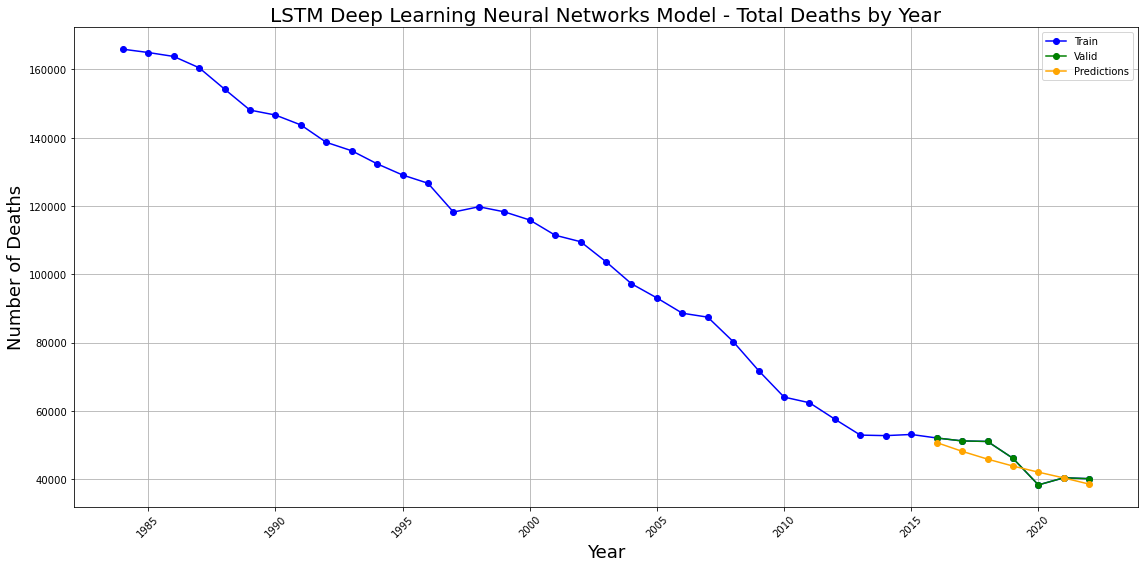

In [184]:
# Plot the graph with interlinked lines and different colors for train, valid, and predictions
plt.figure(figsize=(16,8))
plt.title('LSTM Deep Learning Neural Networks Model - Total Deaths by Year', fontsize=20)
plt.xlabel('Year', fontsize=18)
plt.ylabel('Number of Deaths', fontsize=18)

# Concatenate train and valid to ensure the lines are continuous
df_combined = pd.concat([train, valid])

# Plot train and valid interlinked with different colors
plt.plot(df_combined['year'], df_combined['total_value'], marker='o', linestyle='-', color='blue', label='Train')

# Highlight the validation part in yellow
plt.plot(valid['year'], valid['total_value'], marker='o', linestyle='-', color='green', label='Valid')

# Plot the predictions interlinked, but highlighted in green
plt.plot(valid['year'], valid['Predictions'], marker='o', linestyle='-', color='orange', label='Predictions')

# Final adjustments
plt.legend(['Train', 'Valid', 'Predictions'], loc='upper right')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()

## RNN for Total Deaths by Year and Sex - Male

### Creating a Loop to Define Training Variables and the Target Variable

In [90]:
x_train_dr_sex_male =[]
y_train_dr_sex_male =[]
 
for i in range(previous_years, len(train_data_dr_sex_male)):
    x_train_dr_sex_male.append(train_data_dr_sex_male[i-previous_years:i,0])
    y_train_dr_sex_male.append(train_data_dr_sex_male[i,0])
    
x_train_dr_sex_male = np.array(x_train_dr_sex_male)
y_train_dr_sex_male = np.array(y_train_dr_sex_male)

#### Normalizing Train Data

In [91]:
scaler = MinMaxScaler(feature_range=(0, 1))
x_train_scaled_sex_male = scaler.fit_transform(x_train_dr_sex_male)
y_train_scaled_sex_male = scaler.fit_transform(y_train_dr_sex_male.reshape(-1, 1))

- Converting in Numpy Arrays to Train the LTSM Neural Net model

In [92]:
x_train_scaled_sex_male =np.reshape(x_train_scaled_sex_male,(x_train_scaled_sex_male.shape[0], x_train_scaled_sex_male.shape[1],1))
x_train_scaled_sex_male.shape

(17, 15, 1)

### Building the Model LSTM Neural Net Model

In [148]:
model_dr_sex_male  = Sequential()
model_dr_sex_male .add(LSTM(25, return_sequences = True, input_shape = (x_train_scaled_sex_male.shape[1], 1)))
model_dr_sex_male.add(TimeDistributed(Dense(25)))
model_dr_sex_male.add(LSTM(20, return_sequences = False))
model_dr_sex_male.add(Dense(15, kernel_regularizer=l2(0.001)))
model_dr_sex_male.add(Dense(10))
model_dr_sex_male.add(Dense(1)) 

### Compiling the Model

In [149]:
optimizer = Adam(learning_rate=0.0005)
model_dr_sex_male.compile(loss='mean_squared_error', optimizer=optimizer)

### Training the Model

In [150]:
model_dr_sex_male.fit(x_train_scaled_sex_male, y_train_scaled_sex_male, batch_size = 16, epochs = 50)

Epoch 1/50
2/2 [==============================] - 10s 20ms/step - loss: 0.3950
Epoch 2/50
2/2 [==============================] - 0s 22ms/step - loss: 0.3385
Epoch 3/50
2/2 [==============================] - 0s 22ms/step - loss: 0.2906
Epoch 4/50
2/2 [==============================] - 0s 21ms/step - loss: 0.2455
Epoch 5/50
2/2 [==============================] - 0s 20ms/step - loss: 0.2047
Epoch 6/50
2/2 [==============================] - 0s 20ms/step - loss: 0.1717
Epoch 7/50
2/2 [==============================] - 0s 14ms/step - loss: 0.1404
Epoch 8/50
2/2 [==============================] - 0s 23ms/step - loss: 0.1173
Epoch 9/50
2/2 [==============================] - 0s 23ms/step - loss: 0.0996
Epoch 10/50
2/2 [==============================] - 0s 30ms/step - loss: 0.0881
Epoch 11/50
2/2 [==============================] - 0s 21ms/step - loss: 0.0820
Epoch 12/50
2/2 [==============================] - 0s 10ms/step - loss: 0.0808
Epoch 13/50
2/2 [==============================] - 0s 22ms/s

### Testing the Model

In [151]:
test_data_dr_sex_male = dr_sex_male_v[training_data_len -previous_years: , :]

#### Creating a Loop - Test Data

In [152]:
x_test_dr_sex_male = []
y_test_dr_sex_male = dr_sex_male_v[training_data_len:, :]

for i in range(previous_years,len(test_data_dr_sex_male)):
    x_test_dr_sex_male.append(test_data_dr_sex_male[i-previous_years:i, 0])
    
x_test_dr_sex_male = np.array(x_test_dr_sex_male)
y_test_dr_sex_male = np.array(y_test_dr_sex_male)   

#### Normalizing Test Data

In [153]:
scaler = MinMaxScaler(feature_range=(0, 1))
x_test_scaled_sex_male = scaler.fit_transform(x_test_dr_sex_male)
y_test_scaled_sex_male = scaler.fit_transform(y_test_dr_sex_male.reshape(-1, 1))

- Reshaping Test Data

In [154]:
x_test_scaled_sex_male = np.reshape(x_test_scaled_sex_male,(x_test_scaled_sex_male.shape[0], x_test_scaled_sex_male.shape[1],1))

#### Predicting

In [155]:
predictions_sex_male = model_dr_sex_male.predict(x_test_scaled_sex_male)

1/1 [==============================] - 2s 2s/step


In [156]:
predictions_sex_male

array([[1.0581553 ],
       [0.81206363],
       [0.63464755],
       [0.514475  ],
       [0.40951875],
       [0.27747402],
       [0.10736124]], dtype=float32)

#### Unscaling the Data

In [157]:
predictions_sex_male = scaler.inverse_transform(predictions_sex_male)

### Evaluating the Model

In [158]:
rmse = np.sqrt(mean_squared_error(y_test_dr_sex_male,predictions_sex_male))
r2_value = r2_score(y_test_dr_sex_male,predictions_sex_male)
print("Root Mean Square Error: ", rmse)
print("R^2 Value: ", r2_value)

Root Mean Square Error:  996.0068691496772
R^2 Value:  0.7412035864172355


### Plotting the Data

In [159]:
train_sex_male = dr_sex_male[:training_data_len]
valid_sex_male = dr_sex_male[training_data_len:]
valid_sex_male['Predictions'] = predictions_sex_male

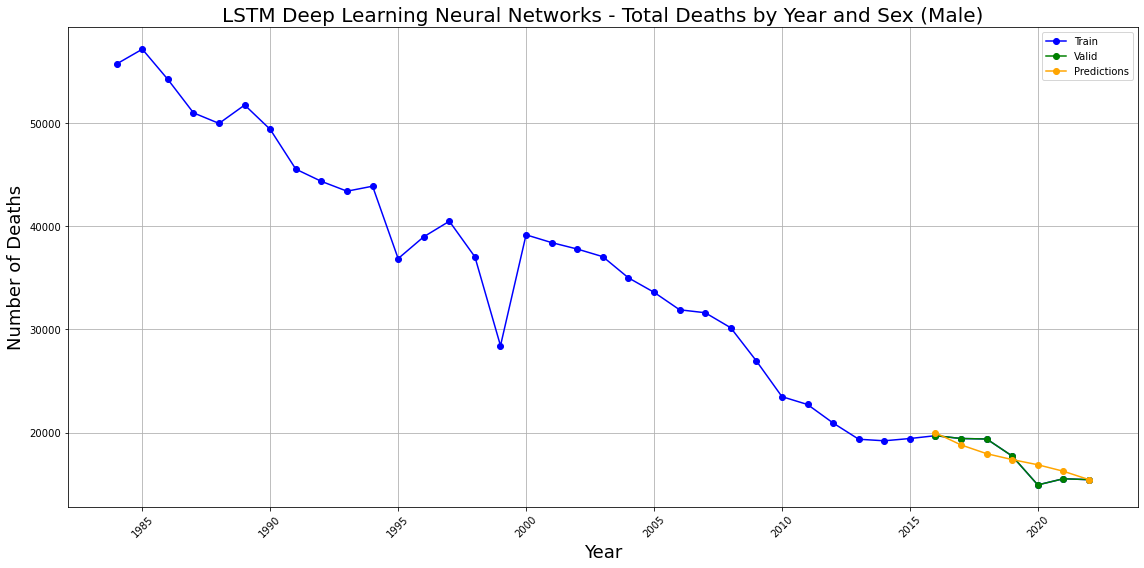

In [160]:
# Plot the graph with interlinked lines and different colors for train, valid, and predictions
plt.figure(figsize=(16,8))
plt.title('LSTM Deep Learning Neural Networks - Total Deaths by Year and Sex (Male)', fontsize=20)
plt.xlabel('Year', fontsize=18)
plt.ylabel('Number of Deaths', fontsize=18)

# Concatenate train and valid to ensure the lines are continuous
df_combined_sex_male = pd.concat([train_sex_male, valid_sex_male])

# Plot train and valid interlinked with different colors
plt.plot(df_combined_sex_male['year'], df_combined_sex_male['total_value'], marker='o', linestyle='-', color='blue', label='Train')

# Highlight the validation part in yellow
plt.plot(valid_sex_male['year'], valid_sex_male['total_value'], marker='o', linestyle='-', color='green', label='Valid')

# Plot the predictions interlinked, but highlighted in green
plt.plot(valid_sex_male['year'], valid_sex_male['Predictions'], marker='o', linestyle='-', color='orange', label='Predictions')

# Final adjustments
plt.legend(['Train', 'Valid', 'Predictions'], loc='upper right')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()

## RNN for Total Deaths by Year and Sex - Female

### Creating a Loop to Define Training Variables and the Target Variable

In [106]:
x_train_dr_sex_female =[]
y_train_dr_sex_female =[]
 
for i in range(previous_years, len(train_data_dr_sex_female)):
    x_train_dr_sex_female.append(train_data_dr_sex_female[i-previous_years:i,0])
    y_train_dr_sex_female.append(train_data_dr_sex_female[i,0])
    
x_train_dr_sex_female = np.array(x_train_dr_sex_female)
y_train_dr_sex_female = np.array(y_train_dr_sex_female)

#### Normalizing Train Data

In [107]:
scaler = MinMaxScaler(feature_range=(0, 1))
x_train_scaled_sex_female = scaler.fit_transform(x_train_dr_sex_female)
y_train_scaled_sex_female = scaler.fit_transform(y_train_dr_sex_female.reshape(-1, 1))

- Converting in Numpy Arrays to Train the LTSM Neural Net model

In [108]:
x_train_scaled_sex_female =np.reshape(x_train_scaled_sex_female,(x_train_scaled_sex_female.shape[0], x_train_scaled_sex_female.shape[1],1))
x_train_scaled_sex_female.shape

(17, 15, 1)

### Building the Model LSTM Neural Net Model

In [135]:
model_dr_sex_female  = Sequential()
model_dr_sex_female .add(LSTM(25, return_sequences = True, input_shape = (x_train_scaled_sex_female.shape[1], 1)))
model_dr_sex_female.add(TimeDistributed(Dense(25)))
model_dr_sex_female.add(LSTM(20, return_sequences = False))
model_dr_sex_female.add(Dense(15, kernel_regularizer=l2(0.001)))
model_dr_sex_female.add(Dense(10)) 
model_dr_sex_female.add(Dense(1)) 

### Compiling the Model

In [136]:
optimizer = Adam(learning_rate=0.0005)
model_dr_sex_female.compile(loss='mean_squared_error', optimizer=optimizer)

### Training the Model

In [137]:
model_dr_sex_female.fit(x_train_scaled_sex_female, y_train_scaled_sex_female, batch_size = 16, epochs = 50)

Epoch 1/50
2/2 [==============================] - 10s 27ms/step - loss: 0.3160
Epoch 2/50
2/2 [==============================] - 0s 21ms/step - loss: 0.2727
Epoch 3/50
2/2 [==============================] - 0s 20ms/step - loss: 0.2335
Epoch 4/50
2/2 [==============================] - 0s 21ms/step - loss: 0.1945
Epoch 5/50
2/2 [==============================] - 0s 26ms/step - loss: 0.1593
Epoch 6/50
2/2 [==============================] - 0s 19ms/step - loss: 0.1284
Epoch 7/50
2/2 [==============================] - 0s 18ms/step - loss: 0.1035
Epoch 8/50
2/2 [==============================] - 0s 21ms/step - loss: 0.0863
Epoch 9/50
2/2 [==============================] - 0s 24ms/step - loss: 0.0757
Epoch 10/50
2/2 [==============================] - 0s 22ms/step - loss: 0.0687
Epoch 11/50
2/2 [==============================] - 0s 22ms/step - loss: 0.0659
Epoch 12/50
2/2 [==============================] - 0s 20ms/step - loss: 0.0634
Epoch 13/50
2/2 [==============================] - 0s 20ms/s

### Testing the Model

In [138]:
test_data_dr_sex_female = dr_sex_female_v[training_data_len -previous_years: , :]

#### Creating a Loop - Test Data

In [139]:
x_test_dr_sex_female = []
y_test_dr_sex_female = dr_sex_female_v[training_data_len:, :]

for i in range(previous_years,len(test_data_dr_sex_female)):
    x_test_dr_sex_female.append(test_data_dr_sex_female[i-previous_years:i, 0])
    
x_test_dr_sex_female = np.array(x_test_dr_sex_female)
y_test_dr_sex_female = np.array(y_test_dr_sex_female)   

#### Normalizing Test Data

In [140]:
scaler = MinMaxScaler(feature_range=(0, 1))
x_test_scaled_sex_female = scaler.fit_transform(x_test_dr_sex_female)
y_test_scaled_sex_female = scaler.fit_transform(y_test_dr_sex_female.reshape(-1, 1))

- Reshaping Test Data

In [141]:
x_test_scaled_sex_female = np.reshape(x_test_scaled_sex_female,(x_test_scaled_sex_female.shape[0], x_test_scaled_sex_female.shape[1],1))

#### Predicting

In [142]:
predictions_sex_female = model_dr_sex_female.predict(x_test_scaled_sex_female)

1/1 [==============================] - 2s 2s/step


In [143]:
predictions_sex_female

array([[ 0.9360957 ],
       [ 0.6706391 ],
       [ 0.48039812],
       [ 0.34989035],
       [ 0.27538353],
       [ 0.14532681],
       [-0.00705965]], dtype=float32)

#### Unscaling the Data

In [144]:
predictions_sex_female = scaler.inverse_transform(predictions_sex_female)

### Evaluating the Model

In [145]:
rmse = np.sqrt(mean_squared_error(y_test_dr_sex_female,predictions_sex_female))
r2_value = r2_score(y_test_dr_sex_female,predictions_sex_female)
print("Root Mean Square Error: ", rmse)
print("R^2 Value: ", r2_value)

Root Mean Square Error:  500.87775138993635
R^2 Value:  0.6461554004733807


### Plotting the Data

In [146]:
train_sex_female = dr_sex_female[:training_data_len]
valid_sex_female = dr_sex_female[training_data_len:]
valid_sex_female['Predictions'] = predictions_sex_female

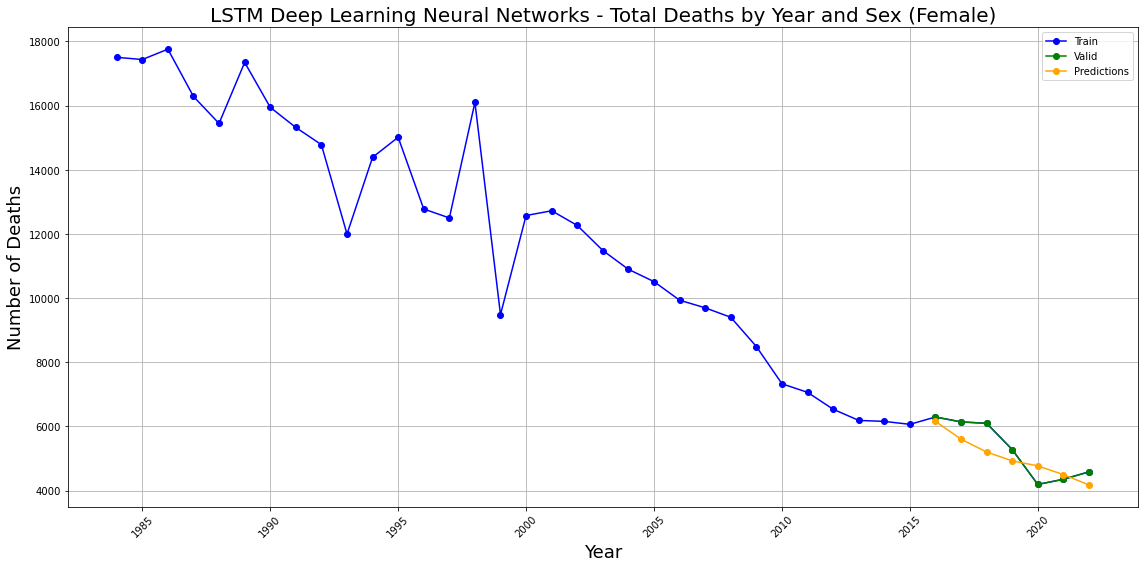

In [147]:
# Plot the graph with interlinked lines and different colors for train, valid, and predictions
plt.figure(figsize=(16,8))
plt.title('LSTM Deep Learning Neural Networks - Total Deaths by Year and Sex (Female)', fontsize=20)
plt.xlabel('Year', fontsize=18)
plt.ylabel('Number of Deaths', fontsize=18)

# Concatenate train and valid to ensure the lines are continuous
df_combined_sex_female = pd.concat([train_sex_female, valid_sex_female])

# Plot train and valid interlinked with different colors
plt.plot(df_combined_sex_female['year'], df_combined_sex_female['total_value'], marker='o', linestyle='-', color='blue', label='Train')

# Highlight the validation part in yellow
plt.plot(valid_sex_female['year'], valid_sex_female['total_value'], marker='o', linestyle='-', color='green', label='Valid')

# Plot the predictions interlinked, but highlighted in green
plt.plot(valid_sex_female['year'], valid_sex_female['Predictions'], marker='o', linestyle='-', color='orange', label='Predictions')

# Final adjustments
plt.legend(['Train', 'Valid', 'Predictions'], loc='upper right')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()